In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#Pembuatan plot
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

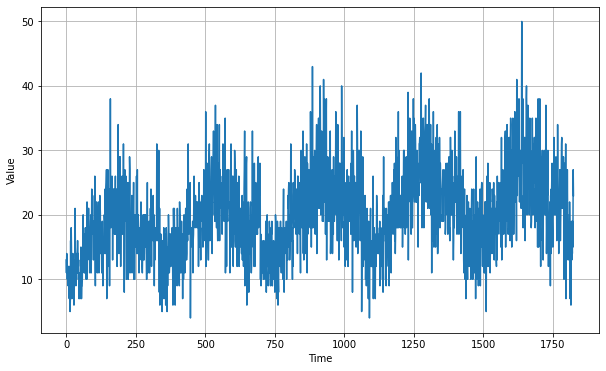

In [4]:
import csv
time_step = []
temps = []

#Input dataset csv berukuran 5 tahun ke array
with open('/tmp/train_store-menu_1.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[3]))
    time_step.append(step)
    step = step + 1
#Input data array ke numpy time & series
series = np.array(temps)
time = np.array(time_step)
#Tampilan plot time series dataset 5 tahun berupa data 1 menu dari 1 restoran
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
#Train set 3 tahun (2013-2015)
split_tv = 1095 #split train valid 
time_train = time[:split_tv]
x_train = series[:split_tv]
#valid set 1 tahun (2016)
split_vt = 1461 #split valid test
time_valid = time[split_tv:split_vt]
x_valid = series[split_tv:split_vt]
#test set 1 tahun (2017)
time_test = time[split_vt:]
x_test = series[split_vt:]

window_size = 29
batch_size = 256
print(x_train)
print(x_valid)
print(x_test)

[13. 11. 14. ... 12. 15. 18.]
[21. 13. 12. 12. 12. 16. 12. 12. 16. 26.  7. 13.  9. 18. 13.  8. 13.  7.
 17. 13. 12. 15. 23. 21. 15. 18. 14. 17. 16. 14. 14. 16. 16. 19.  9. 14.
 14. 18. 12. 14. 16. 14. 15. 10. 23.  8. 19. 29. 17. 18. 18. 21. 16. 16.
 10. 12.  9. 21. 12. 14. 16. 17. 20. 17. 17. 22. 17.  9. 18. 15. 22. 17.
 23. 13. 11. 23. 19. 21. 25. 25. 22. 17. 19. 18. 27. 22. 28. 16. 22. 14.
 17. 32. 24. 29. 18. 20. 25. 18. 23. 22. 36. 18. 30. 24. 22. 23. 22. 18.
 23. 23. 18. 20. 22. 23. 26. 15. 20. 19. 21. 30. 30. 30. 18. 29. 24. 17.
 23. 23. 26. 18. 29. 21. 19. 26. 30. 39. 13. 25. 33. 26. 28. 35. 32. 22.
 26. 29. 17. 26. 33. 29. 18. 18. 24. 25. 38. 28. 35. 23. 22. 22. 24. 34.
 31. 22. 22. 25. 22. 30. 22. 27. 28. 15. 25. 25. 23. 31. 31. 32. 26. 28.
 25. 25. 42. 32. 35. 18. 31. 22. 33. 34. 35. 28. 18. 27. 30. 22. 33. 34.
 37. 24. 25. 22. 34. 26. 34. 25. 21. 24. 28. 30. 30. 38. 31. 21. 22. 28.
 34. 24. 20. 31. 11. 26. 21. 23. 16. 27. 36. 24. 15. 25. 26. 29. 30. 22.
 15. 24. 32. 17. 25. 

In [6]:
def windowed_dataset(series, window_size, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(256)#.prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size)
print(train_set)
print(x_train.shape)
print(valid_set)
print(x_valid.shape)
#Model MLP
model_mlp = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Dense(1)
])
lr = 0.0003
epochs = 200
adam = tf.keras.optimizers.Adam(lr)
model_mlp.compile(loss='mse',
              optimizer=adam,
              metrics=["mae"])
history = model_mlp.fit(train_set, validation_data=valid_set, epochs=epochs)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1095,)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(366,)
Epoch 1/200
5/5 [==============================] - 1s 82ms/step - loss: 424.2937 - mae: 19.5790 - val_loss: 569.0327 - val_mae: 22.9148
Epoch 2/200
5/5 [==============================] - 0s 39ms/step - loss: 411.0150 - mae: 19.2519 - val_loss: 550.9982 - val_mae: 22.5316
Epoch 3/200
5/5 [==============================] - 0s 46ms/step - loss: 398.0471 - mae: 18.9269 - val_loss: 533.3246 - val_mae: 22.1492
Epoch 4/200
5/5 [==============================] - 0s 39ms/step - loss: 385.3476 - mae: 18.6027 - val_loss: 516.0233 - val_mae: 21.7681
Epoch 5/200
5/5 [==============================] - 0s 43ms/step - loss: 372.9243 - mae: 18.2796 - val_loss: 499.1040 - val_mae: 21.3886
Epoch 6/200
5/5 [==============================] - 0s 41ms/step - loss: 360.7833 - mae: 17.9579 - val_loss: 482.5726 

In [19]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 100)         200       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           101       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [9]:
mlp_forecast = model_forecast(model_mlp, series[..., np.newaxis], window_size)
# MLP nya agak aneh, karena mengambil data dari 31 Des 2016 - 30 Des 2017 (mundur 1 index)
mlp_forecast = mlp_forecast[1461 - window_size:-1, -1, 0] 
mlp_forecast+1.5 # MLP forecast nya di tambah nilai sekitar 1.5 biar sesuai (mse dan mae terkecil) 

array([14.921821 , 19.399332 , 15.817323 , 11.339811 , 16.712826 ,
       14.921821 , 23.876844 , 14.921821 , 20.294834 , 18.503828 ,
       12.235313 , 14.921821 , 17.608328 ,  8.652136 , 16.712826 ,
       28.354355 , 15.817323 , 14.921821 , 11.339811 , 16.712826 ,
       22.08584  , 14.026318 , 21.190338 , 10.444309 , 18.503828 ,
       14.921821 , 14.026318 , 11.339811 , 16.712826 , 23.876844 ,
       10.444309 , 17.608328 , 15.817323 , 17.608328 , 23.876844 ,
       24.772346 , 24.772346 , 16.712826 , 13.1308155, 20.294834 ,
       16.712826 , 16.712826 , 18.503828 , 19.399332 , 12.235313 ,
       15.817323 , 22.08584  , 12.235313 , 17.608328 , 22.08584  ,
       18.503828 ,  6.8556128, 14.921821 , 13.1308155, 25.66785  ,
       15.817323 , 16.712826 , 27.458853 , 13.1308155, 20.294834 ,
       16.712826 , 22.98134  , 22.08584  , 14.026318 , 24.772346 ,
       12.235313 , 14.921821 , 17.608328 , 16.712826 , 18.503828 ,
       15.817323 , 21.190338 , 14.921821 , 23.876844 , 22.0858

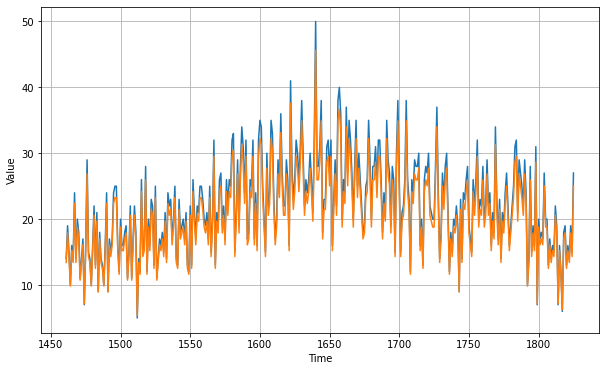

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_test, series[1460:1825] #Data test set diambil dari data 31 Des 2016 - 30 Des 2017
            )
plot_series(time_test, mlp_forecast)


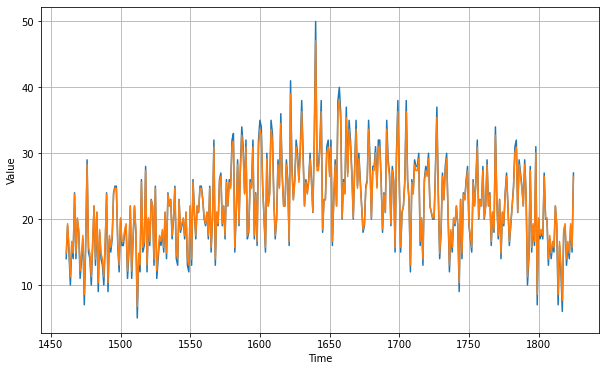

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_test, series[1460:1825] #Data test set diambil dari data 31 Des 2016 - 30 Des 2017
            )
plot_series(time_test, mlp_forecast+1.41)

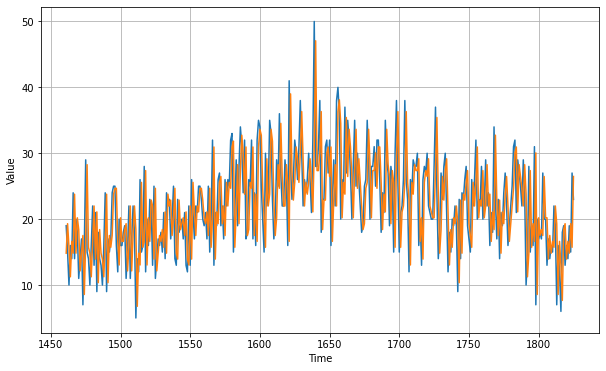

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_test, x_test #Data test set diambil dari data 31 Des 2016 - 30 Des 2017
            )
plot_series(time_test, mlp_forecast+1.41)

In [13]:
tf.keras.metrics.mean_absolute_error(series[1460:1825] #Data test set diambil dari data 31 Des 2016 - 30 Des 2017 
                                     , mlp_forecast+1.41).numpy()

0.58422166

In [14]:
tf.keras.metrics.mean_squared_error(series[1460:1825], mlp_forecast+1.41).numpy()

0.5287878

In [15]:
print(len(mlp_forecast))

365


In [16]:
print(mlp_forecast+1.5)

[14.921821  19.399332  15.817323  11.339811  16.712826  14.921821
 23.876844  14.921821  20.294834  18.503828  12.235313  14.921821
 17.608328   8.652136  16.712826  28.354355  15.817323  14.921821
 11.339811  16.712826  22.08584   14.026318  21.190338  10.444309
 18.503828  14.921821  14.026318  11.339811  16.712826  23.876844
 10.444309  17.608328  15.817323  17.608328  23.876844  24.772346
 24.772346  16.712826  13.1308155 20.294834  16.712826  16.712826
 18.503828  19.399332  12.235313  15.817323  22.08584   12.235313
 17.608328  22.08584   18.503828   6.8556128 14.921821  13.1308155
 25.66785   15.817323  16.712826  27.458853  13.1308155 20.294834
 16.712826  22.98134   22.08584   14.026318  24.772346  12.235313
 14.921821  17.608328  16.712826  18.503828  15.817323  21.190338
 14.921821  23.876844  22.08584   22.98134   17.608328  20.294834
 24.772346  14.921821  14.026318  22.98134   18.503828  19.399332
 20.294834  17.608328  21.190338  14.026318  13.1308155 22.08584
 14.026318

In [17]:
print(series[1460:1825])

[14. 19. 15. 10. 16. 14. 24. 14. 20. 18. 11. 14. 17.  7. 16. 29. 15. 14.
 10. 16. 22. 13. 21.  9. 18. 14. 13. 10. 16. 24.  9. 17. 15. 17. 24. 25.
 25. 16. 12. 20. 16. 16. 18. 19. 11. 15. 22. 11. 17. 22. 18.  5. 14. 12.
 26. 15. 16. 28. 12. 20. 16. 23. 22. 13. 25. 11. 14. 17. 16. 18. 15. 21.
 14. 24. 22. 23. 17. 20. 25. 14. 13. 23. 18. 19. 20. 17. 21. 13. 12. 22.
 13. 26. 21. 17. 22. 21. 25. 25. 23. 20. 19. 21. 17. 25. 15. 20. 32. 13.
 21. 19. 26. 27. 19. 22. 17. 26. 22. 26. 25. 32. 33. 15. 21. 29. 19. 28.
 34. 31. 24. 32. 17. 18. 26. 25. 32. 17. 24. 16. 32. 35. 34. 25. 20. 15.
 30. 22. 24. 35. 33. 23. 17. 20. 29. 25. 36. 27. 22. 22. 29. 26. 16. 41.
 28. 23. 26. 32. 30. 26. 31. 38. 30. 22. 26. 24. 26. 30. 26. 21. 32. 50.
 28. 28. 31. 38. 18. 23. 23. 31. 32. 27. 32. 16. 23. 29. 22. 38. 40. 36.
 20. 26. 24. 37. 27. 35. 32. 27. 20. 28. 35. 25. 30. 26. 22. 18. 19. 25.
 26. 35. 29. 20. 28. 28. 31. 25. 32. 32. 26. 18. 24. 21. 35. 29. 27. 19.
 28. 26. 15. 30. 38. 26. 15. 21. 22. 26. 38. 26. 23

In [18]:
print(x_test)

[19. 15. 10. 16. 14. 24. 14. 20. 18. 11. 14. 17.  7. 16. 29. 15. 14. 10.
 16. 22. 13. 21.  9. 18. 14. 13. 10. 16. 24.  9. 17. 15. 17. 24. 25. 25.
 16. 12. 20. 16. 16. 18. 19. 11. 15. 22. 11. 17. 22. 18.  5. 14. 12. 26.
 15. 16. 28. 12. 20. 16. 23. 22. 13. 25. 11. 14. 17. 16. 18. 15. 21. 14.
 24. 22. 23. 17. 20. 25. 14. 13. 23. 18. 19. 20. 17. 21. 13. 12. 22. 13.
 26. 21. 17. 22. 21. 25. 25. 23. 20. 19. 21. 17. 25. 15. 20. 32. 13. 21.
 19. 26. 27. 19. 22. 17. 26. 22. 26. 25. 32. 33. 15. 21. 29. 19. 28. 34.
 31. 24. 32. 17. 18. 26. 25. 32. 17. 24. 16. 32. 35. 34. 25. 20. 15. 30.
 22. 24. 35. 33. 23. 17. 20. 29. 25. 36. 27. 22. 22. 29. 26. 16. 41. 28.
 23. 26. 32. 30. 26. 31. 38. 30. 22. 26. 24. 26. 30. 26. 21. 32. 50. 28.
 28. 31. 38. 18. 23. 23. 31. 32. 27. 32. 16. 23. 29. 22. 38. 40. 36. 20.
 26. 24. 37. 27. 35. 32. 27. 20. 28. 35. 25. 30. 26. 22. 18. 19. 25. 26.
 35. 29. 20. 28. 28. 31. 25. 32. 32. 26. 18. 24. 21. 35. 29. 27. 19. 28.
 26. 15. 30. 38. 26. 15. 21. 22. 26. 38. 26. 23. 12